In [24]:
import csv
import matplotlib.pyplot as plt
import tensorflow as tf

In [17]:
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # Skip the header
    for row in reader:
        step=0
        for row in reader:
            temps.append(float(row[1]))
            time_step.append(step)
            step = step + 1

series = np.array(temps)
time = np.array(time_step)

In [22]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 128
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(x_train.shape)

(2500,)


In [39]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.GRU(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100,) # callbacks=[lr_schedule]


Epoch 1/100
20/20 [==============================] - 1s 70ms/step - loss: 12.7145 - mae: 13.1963
Epoch 2/100
20/20 [==============================] - 1s 74ms/step - loss: 5.9068 - mae: 6.3962
Epoch 3/100
20/20 [==============================] - 1s 70ms/step - loss: 4.1352 - mae: 4.6165
Epoch 4/100
20/20 [==============================] - 1s 74ms/step - loss: 3.7627 - mae: 4.2445
Epoch 5/100
20/20 [==============================] - 1s 70ms/step - loss: 3.0834 - mae: 3.5568
Epoch 6/100
20/20 [==============================] - 1s 72ms/step - loss: 2.5455 - mae: 3.0100
Epoch 7/100
20/20 [==============================] - 1s 73ms/step - loss: 1.8253 - mae: 2.2775
Epoch 8/100
20/20 [==============================] - 1s 70ms/step - loss: 1.7147 - mae: 2.1642
Epoch 9/100
20/20 [==============================] - 1s 72ms/step - loss: 1.6841 - mae: 2.1334
Epoch 10/100
20/20 [==============================] - 1s 74ms/step - loss: 1.7077 - mae: 2.1569
Epoch 11/100
20/20 [===========================

20/20 [==============================] - 2s 77ms/step - loss: 1.5254 - mae: 1.9680
Epoch 87/100
20/20 [==============================] - 1s 75ms/step - loss: 1.4788 - mae: 1.9197
Epoch 88/100
20/20 [==============================] - 2s 79ms/step - loss: 1.4789 - mae: 1.9201
Epoch 89/100
20/20 [==============================] - 2s 76ms/step - loss: 1.5324 - mae: 1.9760
Epoch 90/100
20/20 [==============================] - 2s 75ms/step - loss: 1.4880 - mae: 1.9289
Epoch 91/100
20/20 [==============================] - 2s 77ms/step - loss: 1.4809 - mae: 1.9219
Epoch 92/100
20/20 [==============================] - 1s 75ms/step - loss: 1.4731 - mae: 1.9139
Epoch 93/100
20/20 [==============================] - 1s 74ms/step - loss: 1.4789 - mae: 1.9200
Epoch 94/100
20/20 [==============================] - 2s 76ms/step - loss: 1.4710 - mae: 1.9118
Epoch 95/100
20/20 [==============================] - 2s 75ms/step - loss: 1.4750 - mae: 1.9159
Epoch 96/100
20/20 [==============================] -

In [40]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

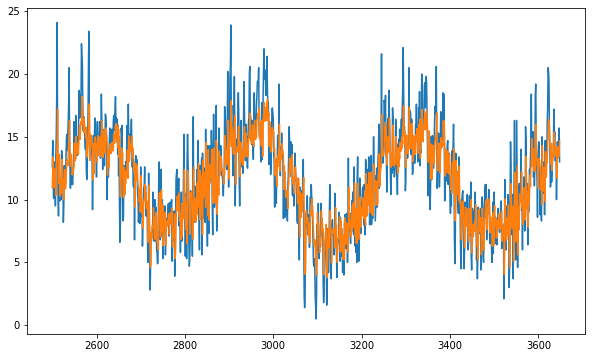

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.show()